<a href="https://colab.research.google.com/github/DS-Jerry-in-Taiwan/project-set/blob/main/Explore_mnist_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My <font color='brown'>MNIST</font> Adventure

本模組使用 [MNIST](http://yann.lecun.com/exdb/mnist/) 手寫數字資料庫，學習 sklearn 套件庫分類演算法的使用法以及鍛鍊各種 Python 技巧。


- [The Story of MNIST database (YouTube Video)](https://www.youtube.com/watch?v=oKzNUGz21JM)


接下來我們**要做這些事**：

Part 1

- 從 Yann LeCun 網站下載原始資料
- 解壓縮 gzip
- 解碼 idx 格式檔案 （MNIST only）
- 將 python 資料寫入 pickle(用以暫存資料的檔案)
- 顯示單一字元 （用 matplotlib）
- 顯示 16 進位內容

-------
Part2

- 用 mnist 資料做 binary classification
	- Perceptron
- 多元分類
	- Logistic Regression
    - yellowbrick/mlxtend 套件介紹
	- Multiple Layer Perceptron
	- SVM


# ★ Importing libraries

In [ ]:
!pip3 install --upgrade yellowbrick mlxtend

     |████████████████████████████████| 276kB 5.1MB/s 
     |████████████████████████████████| 1.4MB 8.9MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [ ]:
  try:
    from google.colab import drive, files
    in_colab = True
except ModuleNotFoundError:
    in_colab = False

if in_colab:
    home_dir = ''
    drive.mount('/content/drive')
    groot_dir = '/content/drive/MyDrive/adventure_time/'
else:
    from pathlib import Path
    home_dir = str(Path.home())
    groot_dir = home_dir + '/Google Drive/adventure_time/'

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('font', size=14)

from datetime import datetime
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
import sklearn
assert sklearn.__version__ >= "0.20"
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import sys
import gdown
import requests
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from pandas.plotting import register_matplotlib_converters

figure_dir = groot_dir + 'figure/'
dataroot_dir = groot_dir
mnist_dir = groot_dir + 'mnist/'

covid_fig = 'covid/'
mnist_fig = 'mnist/'

gfigure = lambda name: figure_dir + name + '.png'
output_fig = lambda name: plt.savefig( gfigure(name), dpi = 300)

local_time = lambda x, offset: x + relativedelta(hours= offset)
def local_now(hours = 8):
    return datetime.now() + relativedelta(hours = hours if in_colab else 0)

def print_now():
    return print('Local Time:', local_now())

def print_local_now():
    return print('Local Time:', local_now())

def fetch_gdrive_file(fid, local_save):
    remote_url = 'https://drive.google.com/uc?id=' + fid
    gdown.download(remote_url, local_save, quiet = False)

def fetch_file_via_requests(url, save_in_dir):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    output_fpath = save_in_dir + local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_fpath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    return output_fpath
        
def acct_string(num):
    s0 = str(num)
    if len(s0) <=3:
        return s0  
    num_section = int(len(s0)/3)
    remaining_start = len(s0) % 3
    s = s0[:remaining_start]
    for i in range(num_section):
        s += ',%s' % s0[remaining_start + i*3 :remaining_start + (i+1)*3]   
    return s

TAIWAN_CSV = '1I5yqulrZSHPSQkxT3oqt_3uVAhPolOEP'
RED_WINE = '1ZDg4EfKkkjsWXfs4L3DkZhnAIfnq98Vk'
TITANIC_TRAIN = '1PrxmUKRQWSlYgtMU13l1E0ob4hVJI20O'
JHU_CSSE = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'
MNIST_TRAIN = '1E-uJ0zqqAfpsVjoOSzqF5TXhDfPNlkQ5'
MNIST_TRAIN_LABEL = '13clNJ2cd2I90W3DEkDBKjZSDNNEqqx3B'
MNIST_TEST = '1zVpVHJl5YABa3qExt1K-O3WaEHXTJekg'
MNIST_TEST_LABEL = '1qci_-dqubnRN-cdrCsbYaUAxyO7_jH9z'

print('\nThis module is amied to explore MNIST dataset...')

print('\nRunning on %s' % sys.platform)
print('Python Version', sys.version)
print('Data storage root points to ==>', groot_dir)
print('MNIST data will be stored at ==>', mnist_dir)
print('\nLibraries and dependenciess imported')
print_local_now()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

This module is amied to explore MNIST dataset...

Running on linux
Python Version 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
Data storage root points to ==> /content/drive/MyDrive/adventure_time/
MNIST data will be stored at ==> /content/drive/MyDrive/adventure_time/mnist/

Libraries and dependenciess imported
Local Time: 2021-05-02 10:13:42.573570


## ✔ Show MNIST digit helper 

### Confusion Matrix and ROC Plotter

In [ ]:
from sklearn.metrics import r2_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib as mpl
import math
import itertools
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

def tf_diag(a):
    b = np.array(a).copy()
    rev_diag = np.diag(np.array(a))[::-1]
    for i, x  in enumerate(rev_diag):
        b[i][i] = x
    return b

def cm_transform(cm):
    newcm = np.zeros(cm.shape)
    for i in range(cm.shape[0]):
        newcm[i] = cm[:,i]
    return newcm.astype(np.int)

def my_plot_confusion_matrix(y_val, y_hat, target_names,
        title='CSP Confusion Matrix',
        figsize = (8, 6),
        cmap=None,
        normalize=True,
        ax = None):
    """
    given the observed and predicted values delivered by a classifier, make 
    a nice plot of the confusion matrix

    Arguments
    ---------
    y_val       : the observed values
    y_hat       : the predictced values
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                see http://matplotlib.org/examples/color/colormaps_reference.html
                plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                If True, plot the proportions
    """

    cm = confusion_matrix(y_val, y_hat)
    cm = tf_diag(cm) if cm.shape[0] == 2 else cm_transform(cm)

    n_classes = cm.shape[0]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    accuracy = accuracy_score(y_val, y_hat)

    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    else:
        fig = ax.figure

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.rcParams['xtick.labelsize']= 14
    plt.rcParams['ytick.labelsize']= 14
    plt.rcParams['axes.titlesize']= 14

    ax.set_title(title, fontsize = 14)
    fig.colorbar(ScalarMappable(norm=None, cmap=cmap), ax=ax)

    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    ax.set(xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=target_names,
        yticklabels=target_names,
        ylabel="Predicted label",
        xlabel="True label")
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            ax.text(j, i, "{:0.3f}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize = 18)
        else:
            ax.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize = 18)

    return ax

print('Loading my confusion matrix plotter ...')
print_local_now()

Loading my confusion matrix plotter ...
Local Time: 2021-05-02 10:13:48.716342


### How to display MNIST digits
如何在畫面中顯示mnist單一手寫字元的source code


- show_mnist_digit(): display bitmapped mnist digit
- show_digit_hex(): show hex value of mnist digit
- numpy.random.[randint](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html)

In [ ]:
def show_mnist_digit(xdata, ydata, digit_index, add_noise = False, 
    title = None,
    outfile = ''):
    d = xdata[digit_index]
    d = np.reshape(d, (28, 28))
    if add_noise:
        anoise = np.random.randint(0, 100, (28, 28))
        d = d + anoise
    plt.imshow(d, cmap=plt.get_cmap('gray_r'))
    
    plt.title( ('mnist index ' if title is None else title) + f'{digit_index:d} = {ydata[digit_index]:d}' , 
        fontsize = 14)
    if (outfile):
        plt.savefig(gfigure(outfile), dpi = 300)
#     plt.show()
    
def show_digit_hex(data, digit_index):
    # if digit_index >= 10000: return
    d = data[digit_index]
    d = np.reshape(d, (28, 28)).astype(np.int)
    # print('begin show digits\n')
    for row in range(0, 28):
        for col in range(0, 28):
            print("%02X " % d[row][col], end="")
        print("") 

def predict_digit_viask(model, images, labels, to_be_checked = None):
        
    if to_be_checked is None:
        to_be_checked = np.random.randint(1, 10000, 1)
        
    d = images[to_be_checked].reshape(1, 28*28)
    y_guess = model.predict(d)

    # print('classifier %s prediction' % model_name)
    print('test set digit index [%d]' % to_be_checked)
    print('answer = %d , predicted = %d\n' % 
        (labels[to_be_checked], y_guess[0]) )
    
    prob_list = model.predict_proba(d)

    fig, ax = plt.subplots(1, 2, figsize=(10,5))

    ax[0].imshow(images[to_be_checked].reshape(28, 28), 
        cmap=plt.get_cmap('gray_r') )
    
    ax[0].set_title('MNIST Test Set: [%d] = %d' \
        % (to_be_checked, labels[to_be_checked]))
    ax[0].grid(b = 'on', alpha = 0.5, ls = '--')
    ax[1].bar(np.arange(10), prob_list[0])
#     ax[1].set_aspect(0.1)
    ax[1].set_xticks(np.arange(10))
    ax[1].set_yticks(np.arange(0,1.1,0.1))

    ax[1].grid('on', color = '#eeeeee', ls = '--')
    ax[1].set_title('Class %d Probability %0.3f' % (np.argmax(prob_list[0]), max(prob_list[0])))
    plt.tight_layout()
    # output_fig(mnist_fig + 'prediction %d' % to_be_checked)

print('Loading mnist digits plotting helpers')
print_now()

Loading mnist digits plotting helpers
Local Time: 2021-05-02 10:13:52.611952


# ① 下載原始檔 (download idx-coded mnist dataset)




檔案格式說明，參考下列連結：

- Yann LeCunn 網站提供 [idx](http://yann.lecun.com/exdb/mnist/) 格式[說明](http://www.fon.hum.uva.nl/praat/manual/IDX_file_format.html)，mlxtend 也提供以 Python 如以 mlxtend 套件[載入資料庫](http://rasbt.github.io/mlxtend/user_guide/data/loadlocal_mnist/)的說明。

- [Kaggle](https://www.kaggle.com/ngbolin/mnist-dataset-digit-recognizer) 上有 csv 格式的說明

- [MNIST Dataset Python Example Using CNN](https://towardsdatascience.com/mnist-cnn-python-c61a5bce7a19)

- [Using MNIST](https://www.python-course.eu/neural_network_mnist.php)

- [np.fromfile](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fromfile.html) API 說明

### MNIST website URL

In [ ]:
train_data_file =   'train-images-idx3-ubyte'
train_label_file =  'train-labels-idx1-ubyte'
test_data_file =  't10k-images-idx3-ubyte'
test_label_file =  't10k-labels-idx1-ubyte'

#原始網址目前無法使用，改為其他下載連結
mnist_host = 'https://storage.googleapis.com/cvdf-datasets/mnist/'

mnist_files = [train_data_file, train_label_file, 
    test_data_file, test_label_file]

### 直接從 Yann Lecun 維護的網站下載資料

- [Python GZip](https://docs.python.org/3/library/gzip.html)
- [How to unzip gz file using Python](https://stackoverflow.com/questions/31028815/how-to-unzip-gz-file-using-python)

- [MNIST dataset provided by Yann Lecun](http://yann.lecun.com/exdb/mnist/)

In [ ]:
%%time
import gzip
import shutil

#gzip套件提供之範本
#
def un_gzip(original,uncompressed):
  with gzip.open(original,'rb') as f_in:
    with open(uncompressed,'wb') as f_out:
      shutil.copyfileobj(f_in,f_out)
      print('%s uncompressed to %s' % (original, uncompressed))


for dfile in mnist_files:
  print(mnist_host + dfile + '.gz')
  remote_file = mnist_host + dfile + '.gz'
  local_file = mnist_dir + dfile + '.gz'
  result = mnist_dir + dfile

  #下載相對應連結的檔案到指定的雲端地址
  fetch_file_via_requests(remote_file,mnist_dir)
  
  #解壓縮本地端的檔案: local_file:本地端路徑與檔案名稱；result:解壓縮路徑與名稱
  un_gzip(local_file,result)

print('mnist data base fetched')
print_now()

https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
/content/drive/MyDrive/adventure_time/mnist/train-images-idx3-ubyte.gz uncompressed to /content/drive/MyDrive/adventure_time/mnist/train-images-idx3-ubyte
https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
/content/drive/MyDrive/adventure_time/mnist/train-labels-idx1-ubyte.gz uncompressed to /content/drive/MyDrive/adventure_time/mnist/train-labels-idx1-ubyte
https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
/content/drive/MyDrive/adventure_time/mnist/t10k-images-idx3-ubyte.gz uncompressed to /content/drive/MyDrive/adventure_time/mnist/t10k-images-idx3-ubyte
https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz
/content/drive/MyDrive/adventure_time/mnist/t10k-labels-idx1-ubyte.gz uncompressed to /content/drive/MyDrive/adventure_time/mnist/t10k-labels-idx1-ubyte
mnist data base fetched
Local Time: 2021-05-01 16:01:13.734203
CPU times: 

### 從遠端 Goggle Drive 下載 ( Fetching shared resources)

In [ ]:
fetch_gdrive_file(MNIST_TRAIN, 
    os.path.join(mnist_dir, train_data_file ))
fetch_gdrive_file(MNIST_TRAIN_LABEL, 
    os.path.join(mnist_dir, train_label_file ))
fetch_gdrive_file(MNIST_TEST, 
    os.path.join(mnist_dir, test_data_file ))
fetch_gdrive_file(MNIST_TEST_LABEL, 
    os.path.join(mnist_dir, test_label_file))

Permission denied: https://drive.google.com/uc?id=1E-uJ0zqqAfpsVjoOSzqF5TXhDfPNlkQ5
Maybe you need to change permission over 'Anyone with the link'?
Permission denied: https://drive.google.com/uc?id=13clNJ2cd2I90W3DEkDBKjZSDNNEqqx3B
Maybe you need to change permission over 'Anyone with the link'?
Permission denied: https://drive.google.com/uc?id=1zVpVHJl5YABa3qExt1K-O3WaEHXTJekg
Maybe you need to change permission over 'Anyone with the link'?
Permission denied: https://drive.google.com/uc?id=1qci_-dqubnRN-cdrCsbYaUAxyO7_jH9z
Maybe you need to change permission over 'Anyone with the link'?


## Read dataset and dump pickle  ✔

Yann LeCunn 維護的 MNIST 資料已經下載回來，放在 ～/Google Drive/adventure_time/mnist/。以下程式將 idx 格式的檔案載入記憶體，以 Pandas DataFrame 格式封裝起來。為了日後使用方便，並將 DataFrame 內容以 Python 內建的 `Pickle` 格式存入本地硬碟。


讀入資料後，分成兩個資料集 `train` & `test`，兩個資料集的 shape 以及資料筆數如下述：

- shape of train_x (60000, 784)
- shape of train_y (60000,)
- shape of test_x (10000, 784)
- shape of test_x (10000,)

dump datafram to pickle 時，應該儲存**沒有處理**過（label smoothing, nomalization）的資料。下次取出來使用的時候，依照當時需求，實驗目的，再做必要的 preprocessing or feature engingeering 即可

### read_idx (要預先載入)

In [ ]:
import struct, pickle
from scipy.ndimage.interpolation import shift


def read_idx(filename):
    with open(filename,'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        if (dims == 3):
            n = struct.unpack('>I', f.read(4))[0]
            r = struct.unpack('>I', f.read(4))[0]
            c = struct.unpack('>I', f.read(4))[0]
            shape = (n, r, c)
        else:
            n = struct.unpack('>I', f.read(4))[0]
            shape = (n)
#         print('idx shape =', shape)
        return np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))


### 讀入 idx file，然後寫入 pickle

In [ ]:
#讀入mnist train data test_data
raw_train = read_idx(mnist_dir + train_data_file)
train_data = np.reshape(raw_train,(60000,28*28))
train_y = read_idx(mnist_dir + train_label_file)

raw_test = read_idx(mnist_dir + test_data_file)
test_data = np.reshape(raw_test,(10000,28*28))
test_y = read_idx(mnist_dir + test_label_file)

#將讀入的idx檔寫入pkl中
with open(mnist_dir + 'clean_mnist.pkl','bw') as fh:
  data = [train_data, train_y,test_data,test_y]
  #Write the pickled representation of the object obj to the open file object file.
  pickle.dump(data,fh)

print_now()

Local Time: 2021-05-01 22:27:20.753450


## 也可以使用 fetch_openml 

-  [fetch_openml](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html?highlight=fetch_openml#sklearn.datasets.fetch_openml) API

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
# mnist.keys()

X, y = mnist["data"], mnist["target"]

Train_X, Train_y= X[:60000], y[:60000]
test_X, test_y = X[:10000], y[10000:]

## Load previously stored pickle for demo purpose

Load the pickled mnist digits into data frames **train_data**, **y_train**, test_data and y_test

In [ ]:
#載入先前所儲存的pickle檔
pkl_path = os.path.join(mnist_dir,'clean_mnist.pkl')

#'br':binary read
with open(pkl_path,'br') as fh:
  #將路徑上的檔案，讀入train_data,train_y,test_data,test_y
  (train_data,train_y,test_data,test_y) = pickle.load(fh)

print(train_data.shape,train_y.shape)
print(test_data.shape,test_y.shape)

print_now()

(60000, 784) (60000,)
(10000, 784) (10000,)
Local Time: 2021-05-01 16:43:10.125976


## How to display hand-written digits ✌

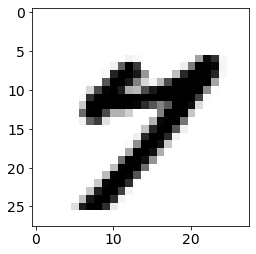

In [ ]:
#給定想要查詢的index
dindex = 1001

d = train_data[dindex]
d = d.reshape(28,28)
plt.imshow(d,cmap='gray_r')

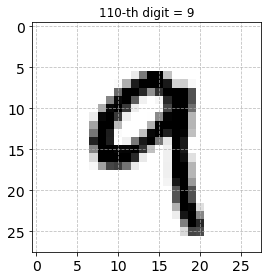

In [ ]:
def mnist_show(xdata,ydata,idx):
  d = xdata[idx]
  d = d.reshape(28,28)
  plt.imshow(d, cmap='gray_r')
  #加入格線（alpha＝0.8）
  plt.grid(b = 'on',ls = '--',alpha = 0.8)
  #加入title
  plt.title(f'{idx}-th digit = {ydata[idx]:d}')
  #調整ticks(將兩軸的ticks調整成一樣)
  plt.xticks(range(0,28,5),['%d'% x for x in range(0,28,5)])
  plt.tight_layout()

mnist_show(train_data,train_y,110)

In [ ]:
#如何展現16位元進位的data
def show_mnist_hex(x_data,idx):
  d = x_data[idx] 
  d = d.reshape(28,28)
  for row in range(0,28):
    for col in range(0,28):
      print('%02X ' % d[row][col],end='')
    print("")


show_mnist_hex(train_data,110)


00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 15 85 FE FE 3D 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 04 51 E2 FD FD FD E4 2C 32 07 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 95 FD FD D7 6F CC FD FD FD AD 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 79 F4 FD A3 0E 00 09 D4 FD FD AD 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 52 F6 FD C4 13 00 00 00 B7 FD FD 90 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 13 F6 FD C6 11 00 00 01 75 FA FD FD 4A 00 00

# ② scikit-learn and MNIST

## ★ Load Pickled MNIST Data

In [ ]:
pkl_path = os.path.join(mnist_dir,'clean_mnist.pkl')

#載入pkl檔
with open(pkl_path,'br') as hf:
  (train_data,train_y,test_data,test_y) = pickle.load(hf)

print("pkl data load into memory ")

pkl data load into memory 


#Label Smoothing
Label Smoothing Regularization（LSR）是一種通過在輸出y中添加噪聲，實現對模型進行約束，降低模型過擬合（overfitting）程度的一種約束方法

原文網址：https://kknews.cc/education/6pm9pgp.html

####參考資料：
[标签平滑（Label Smoothing）——分类问题中错误标注的一种解决方法](https://www.datalearner.com/blog/1051561454844661)

[When Does Label Smoothing Help?](https://papers.nips.cc/paper/2019/file/f1748d6b0fd9d439f71450117eba2725-Paper.pdf)

In [ ]:
#使用label smoothing 使資料不要出現過度擬合(overfitting)的狀況
fac = 0.99/255 #normalization:將資料限縮在 0~1 之間的權數

train_x = train_data * fac + 0.01 #lable smoothing:在normalization後增加白噪音(0.01)
test_x = test_data * fac + 0.01   #使資料較不會overfiting



1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: label, dtype: int64

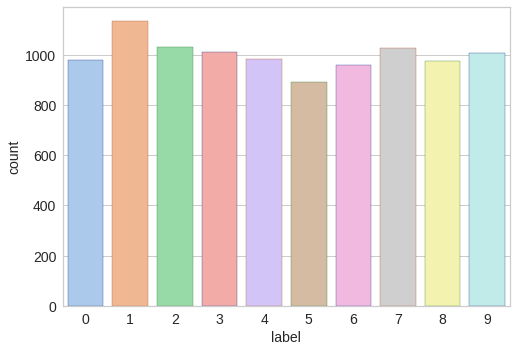

In [ ]:
#檢視資料分布：是否balance
#因為資料及的特性只能針對數量進行探索
cnt = pd.DataFrame()
cnt['label']=test_y
x = sns.countplot(x ='label',data=cnt,
                  palette="pastel",#adjust bar color
                  edgecolor=sns.color_palette("dark", 3))#adjust adge color of bar
cnt['label'].value_counts()

## Binary Classification
- [SGDClassfier: regularized linear models with stochastic gradient descent (SGD) learning](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [Cross Validation Score (cross_val_score)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html?highlight=cross_val_score#sklearn.model_selection.cross_val_score)
- [sklearn.metrics.plot_confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html?highlight=plot_confusion_matrix#sklearn.metrics.plot_confusion_matrix)

- 過程：將x_data(影像檔)輸入model中計算屬於特定字符的機率，以此判斷T/F
用y_data(數值檔)進行確認

### 向感知器致敬

In [ ]:
#選擇一個數字，判別資料點是否等於該值 --> 二元分類的概念
train_y_9 =  (train_y==9);type(train_y_9) #新增資料及：判斷是否為９的結果
test_y_9 = (test_y == 9);type(test_y_9)

#確認值是否正確
print(test_y[:10]);print(test_y_9[:10])


[7 2 1 0 4 1 4 9 5 9]
[False False False False False False False  True False  True]


In [ ]:
from sklearn.linear_model import Perceptron

pen = Perceptron()
pen.fit(train_x,train_y_9) #因為是二元分類，所以y 值必須放T/F值

y_hat = pen.predict([test_x[0]])#輸入predict function必須是陣列 --> []
print(train_y_9[0],train_y[0])#ˇ檢視預測結果跟實際值


False 5


              precision    recall  f1-score   support

       False       0.98      0.96      0.97      8991
        True       0.71      0.85      0.77      1009

    accuracy                           0.95     10000
   macro avg       0.85      0.90      0.87     10000
weighted avg       0.96      0.95      0.95     10000



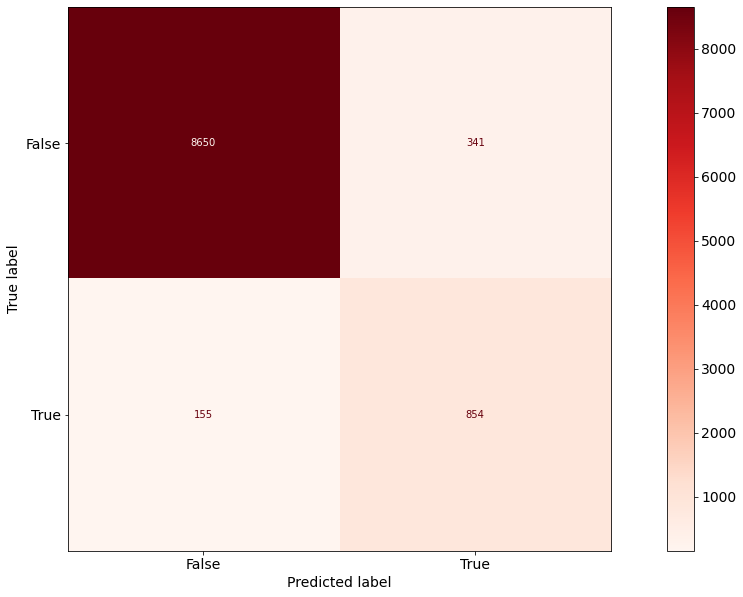

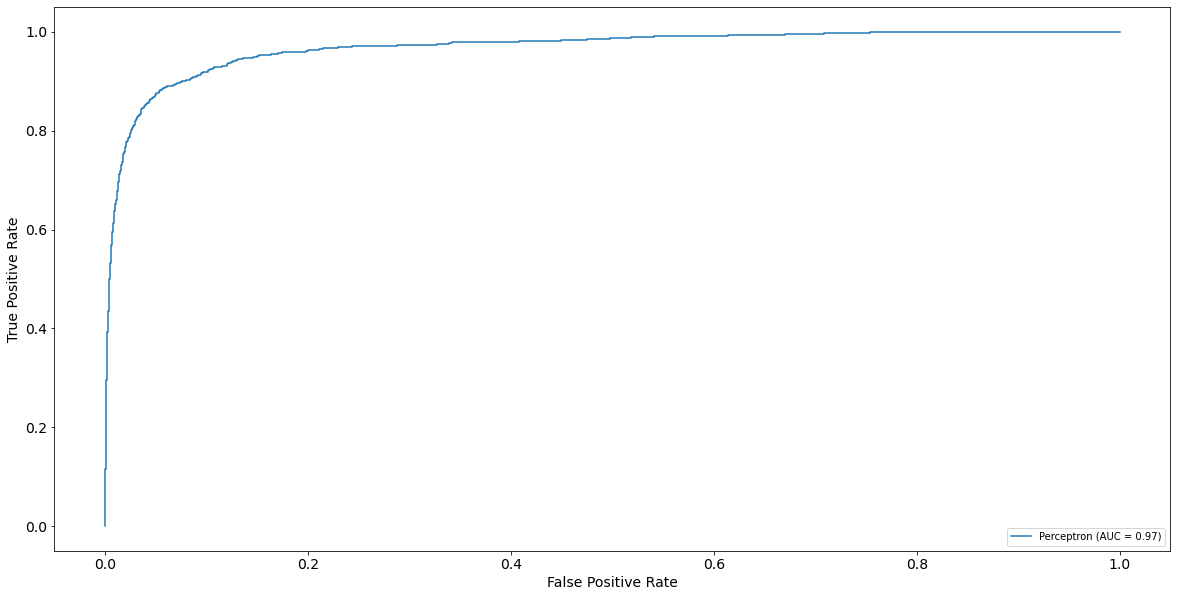

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix,plot_roc_curve

y_hat = pen.predict(test_x)
rep = classification_report(test_y_9,y_hat)

print(rep) #需使用print()，否則資料格式將會跑掉
#perceptron 效果普通但很快

#混淆矩陣
fig,ax = plt.subplots(figsize = (20,10))
plot_confusion_matrix(pen,test_x,test_y_9,
           ax=ax,cmap="Reds",
           values_format='d'#將科學記號轉換成整數符號，便於閱讀
                      )

#ROC_Curve：衡量binary classification 成效指標，無法使用在multi
fig,ax = plt.subplots(figsize=(20,10))
plot_roc_curve(pen,test_x,test_y_9,ax=ax)



In [ ]:
%%time
#cross validate score
#model_selection:協助判斷如何提整資料格式達到最適結果(K-fold判斷、切割比例、training size是否調整)
from sklearn.model_selection import cross_val_score
pen = Perceptron()
scores = cross_val_score(pen,train_x,train_y_9,cv=5)#CV：分組的數量 -->會列出五組SCORE，對應資料區分五組後各自計算的分數
                           #分出的各組score表示資料離散程度，越離散差異越大
print(scores)
print_now()

[0.95566667 0.93791667 0.95466667 0.95041667 0.93383333]
Local Time: 2021-04-30 23:19:25.348901
CPU times: user 5.33 s, sys: 434 ms, total: 5.77 s
Wall time: 5.26 s


In [ ]:

#cross validate score
#model_selection:協助判斷如何提整資料格式達到最適結果(K-fold判斷、切割比例、training size是否調整)
from sklearn.model_selection import cross_val_score
pen2 = Perceptron()
pen2.fit(train_x,train_y_9)
scores = cross_val_score(pen2,train_x,train_y_9,cv=5)#CV：分組的數量
print(scores)
print_now()

[0.95566667 0.93791667 0.95466667 0.95041667 0.93383333]
Local Time: 2021-04-30 23:21:09.986878


### SGD Classifier

In [ ]:
%%time

from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(max_iter = 1000, tol = 1e-3, random_state = 42)
clf.fit(train_x,train_y_9)
y_hat_sgd=clf.predict(test_x)

print_now()

rep =classification_report(test_y_9,y_hat_sgd)
print(rep)#SGD效果較perceptron精準

Local Time: 2021-05-01 16:18:17.248181
              precision    recall  f1-score   support

       False       0.97      0.99      0.98      8991
        True       0.92      0.72      0.81      1009

    accuracy                           0.97     10000
   macro avg       0.95      0.86      0.90     10000
weighted avg       0.96      0.97      0.96     10000

CPU times: user 2.93 s, sys: 13.8 ms, total: 2.95 s
Wall time: 2.91 s


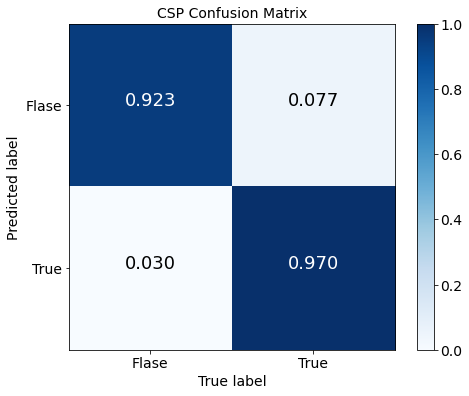

In [ ]:
my_plot_confusion_matrix(test_y_9,y_hat_sgd,['Flase','True'])#業師手動創造的版本，但建議直接使用現成套件，會較有效率

## Multi-class Classification

### Logistic Regression

- [sklearn: Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Linear Model](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

- 使用羅吉斯回歸進行多元分類之預測 --> 未調整其他參數下進行簡易測試

In [ ]:
train_x;train_y

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
#使用Logisticregression進行測試
lr = LogisticRegression(max_iter =500)#迭代次數限制在500

lr.fit(train_x,train_y)

#在此處就已經完成預測，故之後將對成效進行分析與展示
y_hat_lr = lr.predict(test_x)


#列印出accuracy score
print("\n-----------------------------------------")
print("train score: %.4f"%lr.score(train_x,train_y))
print("test score: %.4f"%lr.score(test_x,test_y))
print("\n-----------------------------------------")

#1-9的precesion跟record都會列印出來;accuracy則是取平均
rep = classification_report(test_y,y_hat_lr)
print(rep)
print_now()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



-----------------------------------------
train score: 0.9392
test score: 0.9257

-----------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.90      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000

Local Time: 2021-05-02 07:52:14.730967
CPU times: user 6min 3s, sys: 34.4 s, total: 6min 37s
Wall time: 3min 23s


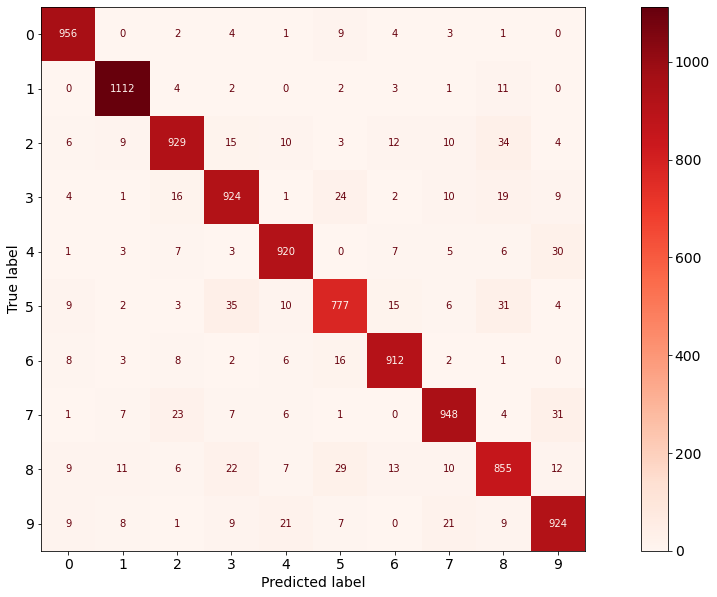

In [ ]:

#繪製繪製cofusion matrix
fig,ax = plt.subplots(figsize = (20,10))
plot_confusion_matrix(lr,test_x,test_y,ax=ax,cmap='Reds',values_format="d")

[[2.77851054e-04 3.69712557e-04 9.61742679e-05 2.86826858e-04
  9.05329205e-01 1.39997952e-03 2.31506206e-04 2.19155744e-03
  3.06458362e-04 8.95107287e-02]]
the prediction is 4,and real number is 4


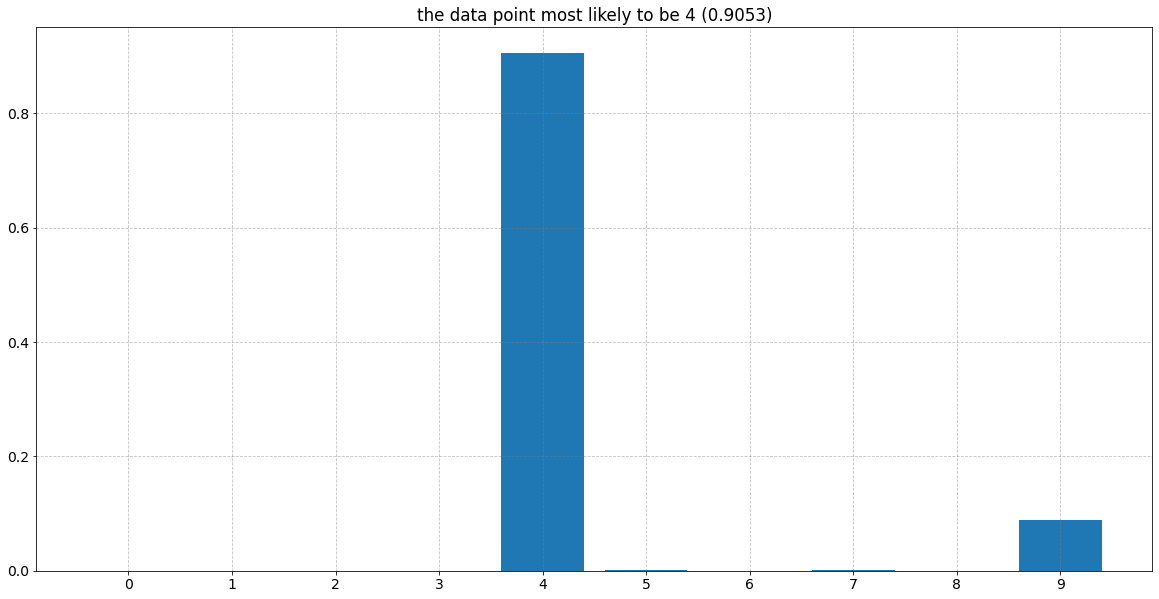

In [ ]:
#選擇想要看的idx
idx=1080

#因為無法使用ROC curve，改採PROBA:計算出各個數值的機率，然後Bar chart 視覺化結果
probas = lr.predict_proba([test_x[idx]])#argument需要是一個陣列
print(probas) #test_x第一個資料點可能是哪個字符的機率

print("the prediction is %d,and real number is %d"
      %(np.argmax(probas),test_y[idx],))

#視覺化資料點的機率
fig,ax = plt.subplots(figsize = (20,10))
ax.bar(range(10),probas[0])
ax.set_title("the data point most likely to be %d (%.4f)"%(np.argmax(probas),probas[0][np.argmax(probas)]))
ax.set_xticks(range(10))
ax.grid(b="best",ls="--",color="gray",alpha=.5)


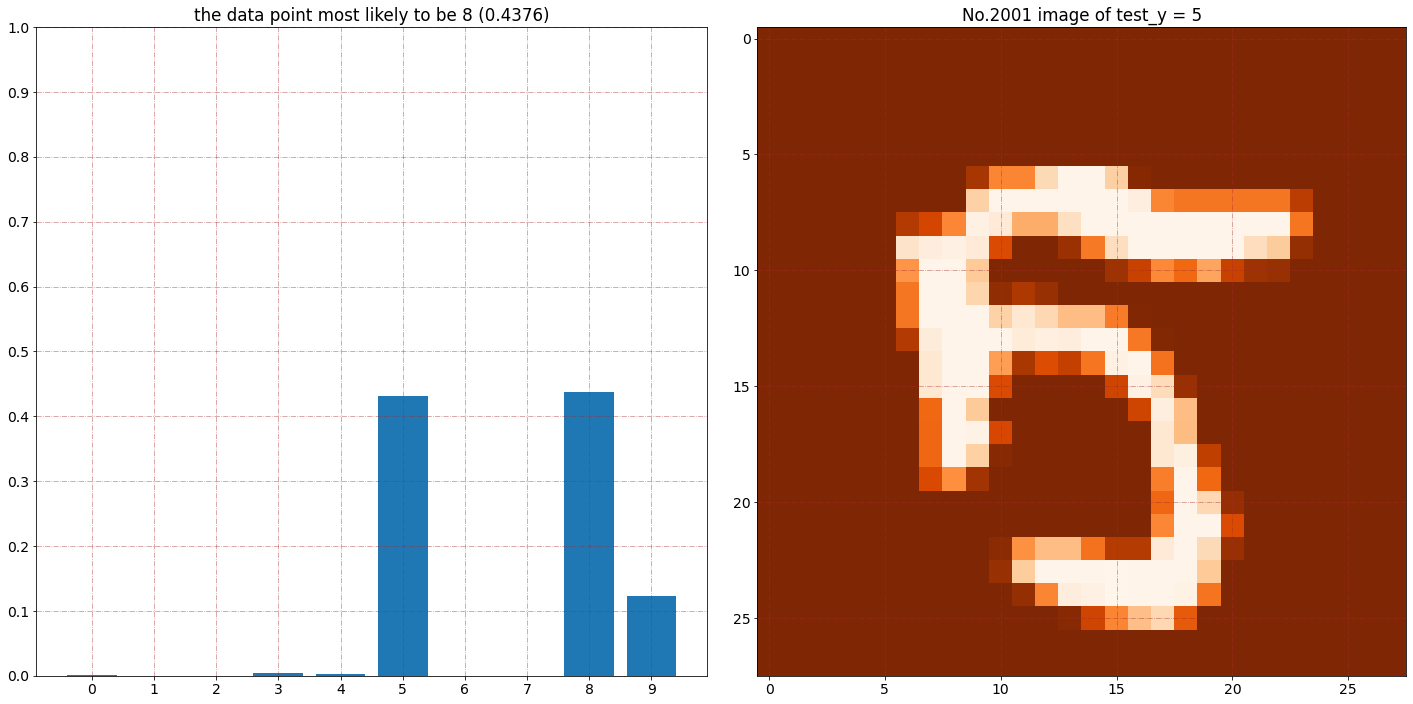

In [ ]:
#結合圖片與機率bar chart
idx = 2001
fig,ax=plt.subplots(1,2,figsize=(20,10))

#label圖檔
d = test_x[idx].reshape(28,28)
ax[1].imshow(d,cmap="Oranges_r",alpha=1)
ax[1].set_title("No.%d image of test_y = %d"%(idx,test_y[idx]))
ax[1].grid(b="best",ls='-.',color="brown",alpha=.5)

#機率bar chart
probas = lr.predict_proba([test_x[idx]])[0]
ax[0].bar(range(10),probas)
ax[0].set_xticks(range(10))
ax[0].set_yticks(np.arange(0,1.1,0.1))#np.ararnge：可接受非int之參數
ax[0].grid(b="best",ls='-.',color="brown",alpha=.5)
ax[0].set_title("the data point most likely to be %d (%.4f)"%(np.argmax(probas),probas[np.argmax(probas)]))

plt.tight_layout()

test set digit index [200]
answer = 3 , predicted = 3



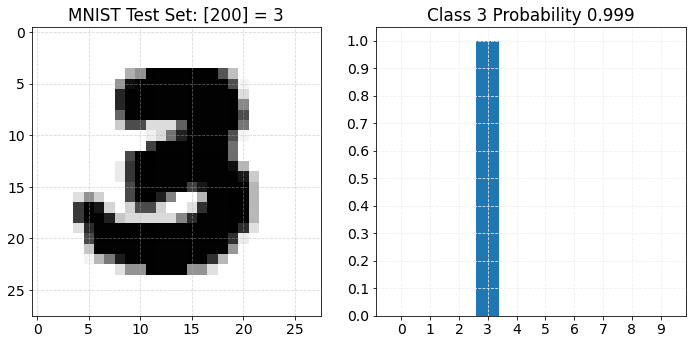

In [ ]:
#(業師製作)現成繪圖function
predict_digit_viask(lr,test_x,test_y,200)

In [ ]:
#檢查有多少預測錯誤值
lr_err_ls=[]

for i in range(len(test_y)):
  if y_hat_lr[i] != test_y[i]:
    lr_err_ls.append(i)

print("Total wrong prediction numbers：%d"%len(lr_err_ls))

Total wrong prediction numbers：743


### YellowBrick ClassificationReport

- [YellowBrick](https://www.scikit-yb.org/en/latest/quickstart.html) [ClassificationReport](https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html) API



In [ ]:
digits = ['%d' % i for i in range(10)]
digits

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


AttributeError: ignored

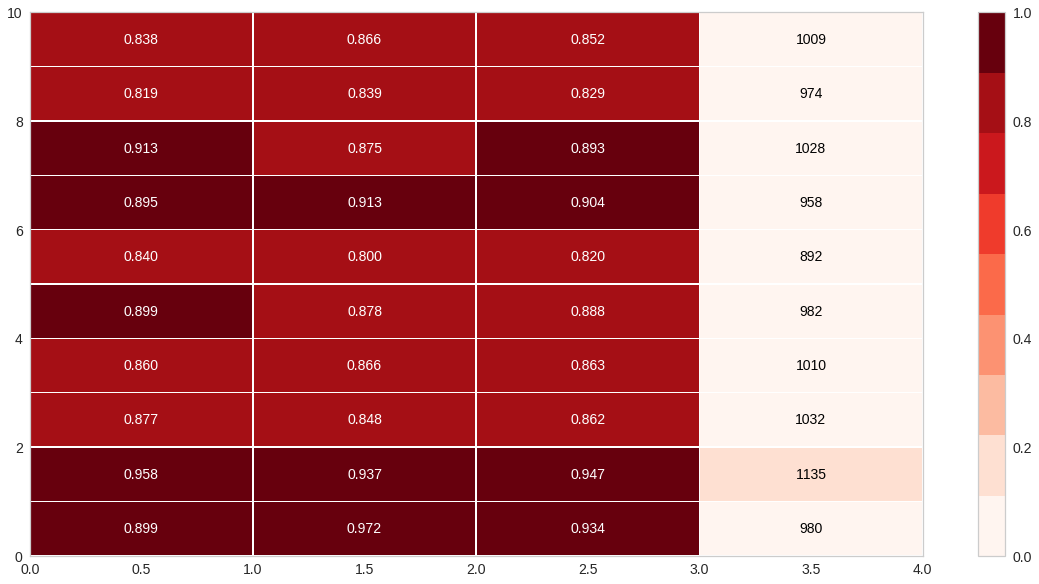

In [ ]:
%%time
from yellowbrick.classifier import ClassificationReport
# from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(max_iter=10)
digits = ['%d' % i for i in range(10)]

plt.figure(figsize=(20,10))
#yellowbrick.classificationReport運作：fit model --> get the test score --> visualize result
#1. 新創insance：model,classes_label,color,support(Specify if support will be displayed)
visualizer = ClassificationReport(lg,classes=digits,support=True,cmap="Reds")
#2. fit instance(model)
visualizer.fit(train_x,train_y)
#3. get score(sklearn.metrics.accuracy_score())
visualizer.score(test_x,test_y)
visualizer.show()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import GaussianNB

from yellowbrick.datasets import load_occupancy
from yellowbrick.classifier import classification_report

# Load the classification data set
X, y = load_occupancy()

# Specify the target classes
classes = ["unoccupied", "occupied"]

# Create the training and test data
tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Instantiate the visualizer
visualizer = classification_report(
    GaussianNB(), X_train, y_train, X_test, y_test, classes=classes, support=True
)

ImportError: ignored

### mlxtend plot_confusion_matrix

- mlxtend [plot_confusion_matrix](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/) user guide

(Google Colab 提供的版本太舊，需要自行安裝最新版)

```
!pip3 install --upgrade mlxtend
```

In [ ]:
!pip3 install --upgrade mlxtend

     |████████████████████████████████| 1.4MB 5.4MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


#### same as sklearn, but more sphiscated

CPU times: user 65.2 ms, sys: 0 ns, total: 65.2 ms
Wall time: 68.6 ms


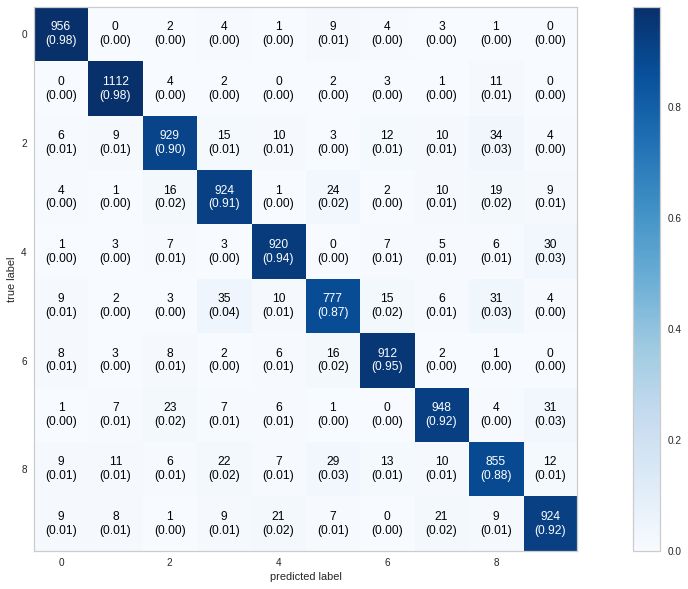

In [ ]:
%%time

#使用mlxtend畫confusion matrix：先用sklean計算confusion matrix然後在繪製confusion matrix plot
from mlxtend.plotting import plot_confusion_matrix as plot_cm3
from sklearn.metrics import confusion_matrix

# 1.計算confusion matrix
mlx_cm = confusion_matrix(test_y,y_hat_lr)

# 2. plot confusion matrix
fig,ax=plot_cm3(conf_mat=mlx_cm,show_normed=True,#show_normed：顯示normalization的結果
                colorbar=True,figsize=(20,10))


### k-Nearest Neighbor
- [KNN資料1]("https://pyecontech.com/2020/04/19/knn/")
- [KNN資料2]("https://tw511.com/a/01/6889.html")

In [ ]:
%%time
# k-Nearest Neighbor：精準但需要很長時間運行
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn = KNeighborsClassifier(n_neighbors=3,algorithm="auto")
knn.fit(train_x,train_y)
y_hat_knn = knn.predict(test_x)
rep = classification_report(test_y,y_hat_knn)
print(rep)


### Multi Layer Perceptron

In [ ]:
%%time
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

#MLP(multi layer perceptron)
#此處僅簡單的演練如何使用，主要用於比較MLP的效果
#細部參數微調留在後面章節
mlp = MLPClassifier(hidden_layer_sizes=128,
           max_iter=100,
           activation='tanh',
           solver='adam',
           tol=1E-4,
           random_state=0,
           learning_rate_init=0.005,#起始學習率
           shuffle=True,
           verbose=False,#是否在運算過程中列出訊息：False
           learning_rate='adaptive')
mlp.fit(train_x,train_y)
y_hat_mlp = mlp.predict(test_x)
rep = classification_report(test_y,y_hat_mlp)
print(rep)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.94      0.97      0.95      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.95      0.96       892
           6       0.98      0.97      0.98       958
           7       0.98      0.95      0.97      1028
           8       0.95      0.97      0.96       974
           9       0.95      0.98      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

CPU times: user 2min 22s, sys: 1min, total: 3min 23s
Wall time: 1min 43s


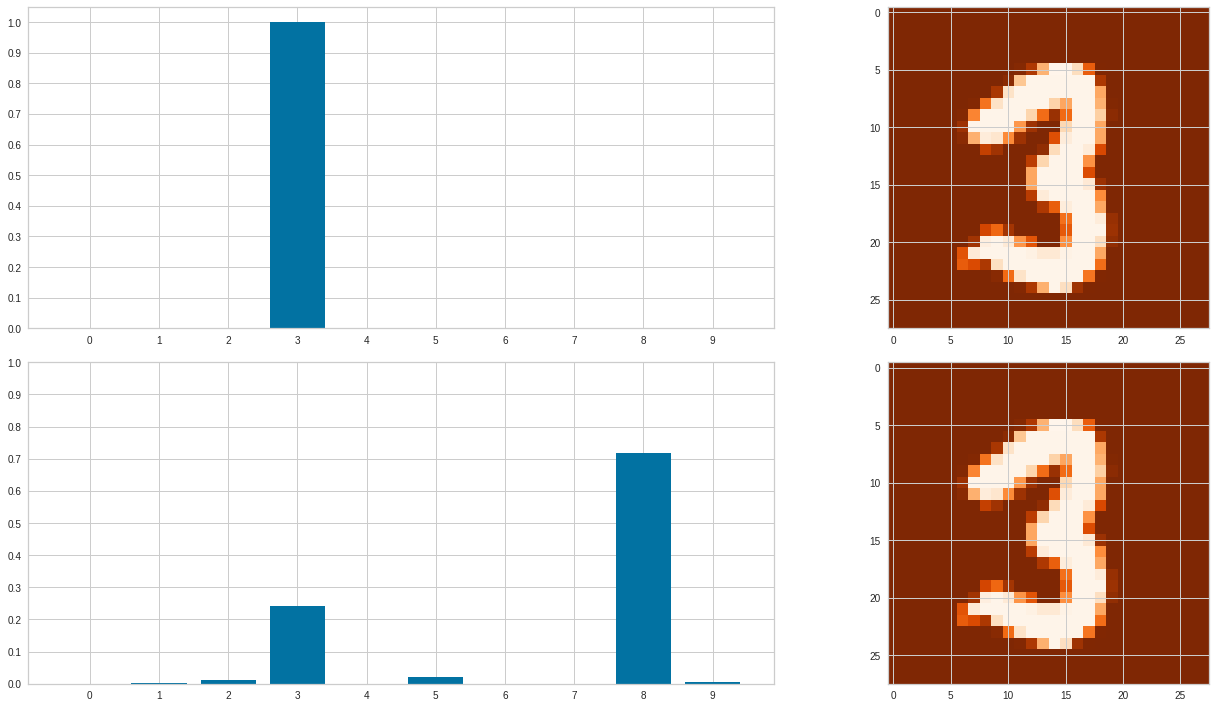

In [ ]:
idx=9986
fig,ax=plt.subplots(2,2,figsize=(20,10))

#mlp output
proba = mlp.predict_proba([test_x[idx]])[0]
ax[0][0].bar(range(10),proba)
ax[0][0].set_xticks(range(10))
ax[0][0].set_yticks(np.arange(0,1.1,0.1))

d=test_x[idx].reshape(28,28)
ax[0][1].imshow(d,cmap="Oranges_r",)


#linear regression output
proba = lr.predict_proba([test_x[idx]])[0]
ax[1][0].bar(range(10),proba)
ax[1][0].set_xticks(range(10))
ax[1][0].set_yticks(np.arange(0,1.1,0.1))

d=test_x[idx].reshape(28,28)
ax[1][1].imshow(d,cmap="Oranges_r",)
plt.tight_layout()

### SVM

- [sklearn Support Vector Machines](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)

In [ ]:
from sklearn.svm import SVC,LinearSVC
#兩者邏輯上屬於同一種方法，只是底層數學運算方法不一樣
sv = SVC(kernel='Linear')
svl = LinearSVC()

# 下一個單元

- https://reurl.cc/g7y7Ab